<div><div style="float:left; clear:both;"><img src="img/colab.png" align="left" width="200" height="200" /><br></div><div style="float:left; clear:both;"><a href="https://colab.research.google.com/drive/1O5sPD2ktmODXE3yyKU2VZz6kIN_-a1eM">Abre este Jupyter en Google Colab</a></div></div>

# Caso práctico: _Random Forest_

En este caso de uso práctico se pretende resolver un problema de detección de malware en dispositivos Android mediante el análisis del tráfico de red que genera el dispositivo mediante el uso de conjuntos de árboles de decisión.

## Conjunto de datos: Detección de malware en Android

### Descripción
The sophisticated and advanced Android malware is able to identify the presence of the emulator used by the malware analyst and in response, alter its behavior to evade detection. To overcome this issue, we installed the Android applications on the real device and captured its network traffic. See our publicly available Android Sandbox.

CICAAGM dataset is captured by installing the Android apps on the real smartphones semi-automated. The dataset is generated from 1900 applications with the following three categories:

**1. Adware (250 apps)**
* Airpush: Designed to deliver unsolicited advertisements to the user’s systems for information stealing.
* Dowgin: Designed as an advertisement library that can also steal the user’s information.
* Kemoge: Designed to take over a user’s Android device. This adware is a hybrid of botnet and disguises itself as popular apps via repackaging.
* Mobidash: Designed to display ads and to compromise user’s personal information.
* Shuanet: Similar to Kemoge, Shuanet also is designed to take over a user’s device.

**2. General Malware (150 apps)**
* AVpass: Designed to be distributed in the guise of a Clock app.
* FakeAV: Designed as a scam that tricks user to purchase a full version of the software in order to re-mediate non-existing infections.
* FakeFlash/FakePlayer: Designed as a fake Flash app in order to direct users to a website (after successfully installed).
* GGtracker: Designed for SMS fraud (sends SMS messages to a premium-rate number) and information stealing.
* Penetho: Designed as a fake service (hacktool for Android devices that can be used to crack the WiFi password). The malware is also able to infect the user’s computer via infected email attachment, fake updates, external media and infected documents.

**3. Benign (1500 apps)**
* 2015 GooglePlay market (top free popular and top free new)
* 2016 GooglePlay market (top free popular and top free new)

### Ficheros de datos
* pcap files – the network traffic of both the malware and benign (20% malware and 80% benign)
* <span style="color:green">.csv files - the list of extracted network traffic features generated by the CIC-flowmeter</span>

### Descarga de los ficheros de datos
https://www.unb.ca/cic/datasets/android-adware.html

### Referencias adicionales sobre el conjunto de datos
_Arash Habibi Lashkari, Andi Fitriah A. Kadir, Hugo Gonzalez, Kenneth Fon Mbah and Ali A. Ghorbani, “Towards a Network-Based Framework for Android Malware Detection and Characterization”, In the proceeding of the 15th International Conference on Privacy, Security and Trust, PST, Calgary, Canada, 2017._

## Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import f1_score
import warnings
# Ignoramos algunos warnings que se producen por invocar el modelo sin el nombre de las características
warnings.filterwarnings('ignore', category=UserWarning, message='.*X does not have valid feature names.*')

## Funciones auxiliares

In [2]:
# Construcción de una función que realice el particionado completo
def train_val_test_split(df, rstate=42, shuffle=True, stratify=None):
    strat = df[stratify] if stratify else None
    train_set, test_set = train_test_split(
        df, test_size=0.4, random_state=rstate, shuffle=shuffle, stratify=strat)
    strat = test_set[stratify] if stratify else None
    val_set, test_set = train_test_split(
        test_set, test_size=0.5, random_state=rstate, shuffle=shuffle, stratify=strat)
    return (train_set, val_set, test_set)

In [3]:
def remove_labels(df, label_name):
    X = df.drop(label_name, axis=1)
    y = df[label_name].copy()
    return (X, y)

In [4]:
def evaluate_result(y_pred, y, y_prep_pred, y_prep, metric):
    print(metric.__name__, "WITHOUT preparation:", metric(y_pred, y, average='weighted'))
    print(metric.__name__, "WITH preparation:", metric(y_prep_pred, y_prep, average='weighted'))

## 1. Lectura del conjunto de datos

In [5]:
df = pd.read_csv('All.csv')

## 2. Visualización del conjunto de datos

In [6]:
df.head(10)

,Querylength,domain_token_count,path_token_count,avgdomaintokenlen,longdomaintokenlen,avgpathtokenlen,tld,charcompvowels,charcompace,ldl_url,...,SymbolCount_FileName,SymbolCount_Extension,SymbolCount_Afterpath,Entropy_URL,Entropy_Domain,Entropy_DirectoryName,Entropy_Filename,Entropy_Extension,Entropy_Afterpath,URL_Type_obf_Type
0,0,4,5,5.5,14,4.400000,4,8,3,0,...,1,0,-1,0.726298,0.784493,0.894886,0.850608,NaN,-1.0,Defacement
1,0,4,5,5.5,14,6.000000,4,12,4,0,...,0,0,-1,0.688635,0.784493,0.814725,0.859793,0.0,-1.0,Defacement
2,0,4,5,5.5,14,5.800000,4,12,5,0,...,0,0,-1,0.695049,0.784493,0.814725,0.801880,0.0,-1.0,Defacement
3,0,4,12,5.5,14,5.500000,4,32,16,0,...,0,0,-1,0.640130,0.784493,0.814725,0.663210,0.0,-1.0,Defacement
4,0,4,6,5.5,14,7.333334,4,18,11,0,...,0,0,-1,0.681307,0.784493,0.814725,0.804526,0.0,-1.0,Defacement
5,0,4,8,5.5,14,6.500000,4,22,10,0,...,0,0,-1,0.666676,0.784493,0.814725,0.755658,0.0,-1.0,Defacement
6,0,4,5,5.5,14,7.800000,4,17,10,0,...,0,0,-1,0.682440,0.784493,0.814725,0.766719,0.0,-1.0,Defacement
7,0,4,7,5.5,14,6.285714,4,16,9,0,...,0,0,-1,0.709396,0.784493,0.814725,0.797498,0.0,-1.0,Defacement
8,0,4,6,5.5,14,6.500000,4,16,10,0,...,0,0,-1,0.678242,0.784493,0.814725,0.732258,0.0,-1.0,Defacement
9,0,4,5,5.5,14,3.600000,4,7,3,0,...,1,0,-1,0.740950,0.784493,0.894886,0.894886,NaN,-1.0,Defacement


In [7]:
df.describe()

,Querylength,domain_token_count,path_token_count,avgdomaintokenlen,longdomaintokenlen,avgpathtokenlen,tld,charcompvowels,charcompace,ldl_url,...,SymbolCount_Directoryname,SymbolCount_FileName,SymbolCount_Extension,SymbolCount_Afterpath,Entropy_URL,Entropy_Domain,Entropy_DirectoryName,Entropy_Filename,Entropy_Extension,Entropy_Afterpath
count,36707.000000,36707.000000,36707.000000,36707.000000,36707.000000,36427.000000,36707.000000,36707.000000,36707.000000,36707.000000,...,36707.000000,36707.000000,36707.000000,36707.000000,36707.000000,36707.000000,28239.000000,36471.000000,36667.000000,36701.000000
mean,21.908110,2.857439,8.954668,5.401719,9.746016,4.556261,2.857439,14.976517,10.216117,3.363909,...,1.727545,3.600049,2.685237,1.903261,0.722350,0.842443,0.677459,0.715834,0.508212,-0.208900
std,94.280669,0.906562,4.278406,1.986858,4.856580,2.839388,0.906562,13.351315,10.845807,13.447289,...,2.719231,4.783213,4.557171,4.512421,0.048820,0.066251,0.450683,0.411712,0.519695,0.891581
min,0.000000,2.000000,0.000000,1.500000,2.000000,0.000000,2.000000,0.000000,0.000000,0.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,0.419560,0.561913,-1.000000,-1.000000,-1.000000,-1.000000
25%,0.000000,2.000000,6.000000,4.000000,6.000000,3.000000,2.000000,7.000000,5.000000,0.000000,...,-1.000000,0.000000,0.000000,-1.000000,0.691929,0.795234,0.731621,0.719904,0.000000,-1.000000
50%,0.000000,3.000000,8.000000,5.000000,9.000000,4.100000,3.000000,13.000000,8.000000,0.000000,...,1.000000,1.000000,0.000000,-1.000000,0.723003,0.835752,0.790535,0.785150,0.729292,-1.000000
75%,19.000000,3.000000,11.000000,6.500000,12.000000,5.000000,3.000000,19.000000,12.000000,1.000000,...,3.000000,6.000000,4.000000,3.000000,0.754305,0.884735,0.851410,0.884662,0.910005,0.758695
max,1385.000000,19.000000,68.000000,29.500000,63.000000,105.000000,19.000000,193.000000,142.000000,207.000000,...,24.000000,40.000000,39.000000,40.000000,0.895403,1.000000,0.962479,1.000000,1.000000,1.000000


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36707 entries, 0 to 36706
Data columns (total 80 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Querylength                      36707 non-null  int64  
 1   domain_token_count               36707 non-null  int64  
 2   path_token_count                 36707 non-null  int64  
 3   avgdomaintokenlen                36707 non-null  float64
 4   longdomaintokenlen               36707 non-null  int64  
 5   avgpathtokenlen                  36427 non-null  float64
 6   tld                              36707 non-null  int64  
 7   charcompvowels                   36707 non-null  int64  
 8   charcompace                      36707 non-null  int64  
 9   ldl_url                          36707 non-null  int64  
 10  ldl_domain                       36707 non-null  int64  
 11  ldl_path                         36707 non-null  int64  
 12  ldl_filename      

In [9]:
print("Longitud del conjunto de datos:", len(df))
print("Número de características del conjunto de datos:", len(df.columns))

Longitud del conjunto de datos: 36707
Número de características del conjunto de datos: 80


In [10]:
df["URL_Type_obf_Type"].value_counts()

URL_Type_obf_Type
Defacement    7930
benign        7781
phishing      7586
malware       6712
spam          6698
Name: count, dtype: int64

In [11]:
is_null=df.isna().any()
is_null[is_null]

avgpathtokenlen             True
NumberRate_DirectoryName    True
NumberRate_FileName         True
NumberRate_Extension        True
NumberRate_AfterPath        True
Entropy_DirectoryName       True
Entropy_Filename            True
Entropy_Extension           True
Entropy_Afterpath           True
dtype: bool

In [12]:
is_inf = df.isin([np.inf,-np.inf]).any()
is_inf[is_inf]

argPathRatio    True
dtype: bool

### Buscando correlaciones

In [13]:
# Transformamos la variable de salida a numérica para calcular correlaciones
X = df.copy()
X['URL_Type_obf_Type'] = X['URL_Type_obf_Type'].factorize()[0]

In [14]:
# Calculamos correlaciones
corr_matrix = X.corr()
corr_matrix["URL_Type_obf_Type"].sort_values(ascending=False)

URL_Type_obf_Type              1.000000
SymbolCount_Directoryname      0.329266
dld_url                        0.301209
dld_path                       0.301100
SymbolCount_Domain             0.294999
                                 ...   
delimeter_Count               -0.175986
URLQueries_variable           -0.181182
delimeter_path                -0.218012
Arguments_LongestWordLength   -0.234710
ISIpAddressInDomainName             NaN
Name: URL_Type_obf_Type, Length: 80, dtype: float64

Buscamos infinitos

In [15]:
X.corr()

,Querylength,domain_token_count,path_token_count,avgdomaintokenlen,longdomaintokenlen,avgpathtokenlen,tld,charcompvowels,charcompace,ldl_url,...,SymbolCount_FileName,SymbolCount_Extension,SymbolCount_Afterpath,Entropy_URL,Entropy_Domain,Entropy_DirectoryName,Entropy_Filename,Entropy_Extension,Entropy_Afterpath,URL_Type_obf_Type
Querylength,1.000000,0.045174,0.004259,-0.056154,0.008193,-0.125872,0.045174,0.791216,0.844110,0.953382,...,0.116514,0.110574,0.115224,-0.369418,0.001953,0.045903,-0.048953,0.043039,0.219879,0.134725
domain_token_count,0.045174,1.000000,-0.101013,-0.212984,0.068065,-0.012080,1.000000,0.001817,0.039905,0.053445,...,0.109263,0.076454,0.084297,-0.012043,-0.503515,0.040195,0.057694,0.107429,0.121760,0.294414
path_token_count,0.004259,-0.101013,1.000000,-0.105089,-0.099711,-0.131095,-0.101013,0.459537,0.373155,-0.033006,...,0.400531,0.413817,0.459120,-0.580160,0.060732,-0.168143,-0.229516,-0.133217,0.289864,-0.090678
avgdomaintokenlen,-0.056154,-0.212984,-0.105089,1.000000,0.895807,-0.001910,-0.212984,-0.084126,-0.074916,-0.049760,...,-0.056301,-0.030137,-0.022116,-0.144895,-0.220215,-0.080810,-0.050798,-0.117418,-0.143579,-0.108749
longdomaintokenlen,0.008193,0.068065,-0.099711,0.895807,1.000000,-0.019786,0.068065,-0.023848,-0.006579,0.011607,...,0.021979,0.041137,0.040299,-0.176775,-0.366726,-0.056348,-0.036403,-0.077200,-0.060031,-0.011337
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Entropy_DirectoryName,0.045903,0.040195,-0.168143,-0.080810,-0.056348,0.061114,0.040195,-0.001297,0.031901,0.064202,...,0.270202,0.227253,0.127857,0.059685,0.034711,1.000000,0.956827,0.698936,0.132257,0.155896
Entropy_Filename,-0.048953,0.057694,-0.229516,-0.050798,-0.036403,0.020422,0.057694,-0.129519,-0.099644,-0.030392,...,0.113257,0.075472,0.025991,0.160053,0.002472,0.956827,1.000000,0.693501,0.079252,0.097028
Entropy_Extension,0.043039,0.107429,-0.133217,-0.117418,-0.077200,-0.112182,0.107429,-0.063158,-0.032762,0.028659,...,0.332371,0.302769,0.195378,0.165161,-0.079596,0.698936,0.693501,1.000000,0.265162,0.078213
Entropy_Afterpath,0.219879,0.121760,0.289864,-0.143579,-0.060031,-0.255051,0.121760,0.253234,0.237815,0.148881,...,0.655816,0.596289,0.691322,-0.010528,-0.140735,0.132257,0.079252,0.265162,1.000000,-0.044898


In [16]:
# Se puede llegar a valorar quedarnos con aquellas que tienen mayor correlación
corr_matrix[corr_matrix["URL_Type_obf_Type"] > 0.05]

,Querylength,domain_token_count,path_token_count,avgdomaintokenlen,longdomaintokenlen,avgpathtokenlen,tld,charcompvowels,charcompace,ldl_url,...,SymbolCount_FileName,SymbolCount_Extension,SymbolCount_Afterpath,Entropy_URL,Entropy_Domain,Entropy_DirectoryName,Entropy_Filename,Entropy_Extension,Entropy_Afterpath,URL_Type_obf_Type
Querylength,1.000000,0.045174,0.004259,-0.056154,0.008193,-0.125872,0.045174,0.791216,0.844110,0.953382,...,0.116514,0.110574,0.115224,-0.369418,0.001953,0.045903,-0.048953,0.043039,0.219879,0.134725
domain_token_count,0.045174,1.000000,-0.101013,-0.212984,0.068065,-0.012080,1.000000,0.001817,0.039905,0.053445,...,0.109263,0.076454,0.084297,-0.012043,-0.503515,0.040195,0.057694,0.107429,0.121760,0.294414
avgpathtokenlen,-0.125872,-0.012080,-0.131095,-0.001910,-0.019786,1.000000,-0.012080,-0.004113,0.021883,0.037780,...,-0.179267,-0.151535,-0.237717,-0.014662,0.025137,0.061114,0.020422,-0.112182,-0.255051,0.188715
tld,0.045174,1.000000,-0.101013,-0.212984,0.068065,-0.012080,1.000000,0.001817,0.039905,0.053445,...,0.109263,0.076454,0.084297,-0.012043,-0.503515,0.040195,0.057694,0.107429,0.121760,0.294414
charcompace,0.844110,0.039905,0.373155,-0.074916,-0.006579,0.021883,0.039905,0.946030,1.000000,0.830184,...,0.239746,0.244214,0.230076,-0.638226,0.003651,0.031901,-0.099644,-0.032762,0.237815,0.145064
ldl_url,0.953382,0.053445,-0.033006,-0.049760,0.011607,0.037780,0.053445,0.739051,0.830184,1.000000,...,0.005754,0.004120,-0.004670,-0.331338,0.002309,0.064202,-0.030392,0.028659,0.148881,0.246547
ldl_domain,-0.030022,0.197289,-0.049729,0.089185,0.120057,0.043079,0.197289,-0.059671,-0.051484,0.025256,...,-0.025331,-0.025015,-0.023577,0.019441,-0.050124,-0.048800,-0.023396,-0.018100,-0.028593,0.067313
ldl_path,0.954891,0.044428,-0.030715,-0.053884,0.006155,0.035885,0.044428,0.741956,0.832702,0.998962,...,0.007010,0.005355,-0.003497,-0.332313,0.004566,0.065899,-0.029337,0.029480,0.150314,0.243472
ldl_getArg,0.975698,0.040407,-0.021871,-0.062034,-0.002410,-0.095640,0.040407,0.750067,0.829129,0.981730,...,0.025258,0.021434,0.017706,-0.341241,0.014643,0.056906,-0.034788,0.038585,0.171663,0.211102
dld_url,0.554725,0.067393,0.051252,-0.001653,0.063513,0.232955,0.067393,0.476464,0.589565,0.723857,...,0.038012,0.040509,0.015153,-0.247243,-0.048822,0.084170,-0.008197,0.025877,0.164396,0.301209


## 3. División del conjunto de datos

In [17]:
# Dividimos el conjunto de datos
train_set, val_set, test_set = train_val_test_split(df)

In [18]:
X_train, y_train = remove_labels(train_set, 'URL_Type_obf_Type')
X_val, y_val = remove_labels(val_set, 'URL_Type_obf_Type')
X_test, y_test = remove_labels(test_set, 'URL_Type_obf_Type')

In [19]:
X_train = X_train.drop("argPathRatio", axis=1)
X_val = X_val.drop("argPathRatio", axis=1)
X_test = X_test.drop("argPathRatio", axis=1)

## 4. Escalando el conjunto de datos

Es importante comprender que los árboles de decisión son algoritmos que **no requieren demasiada preparación de los datos** concretamente, no requieren la realización de escalado o normalización. En este ejercicio se va a realizar escalado al conjunto de datos y se van a comparar los resultados con el conjunto de datos sin escalar. De esta forma se demuestra como aplicar preprocesamientos como el escalado puede incluso llegar a afectar al rendimiento del modelo.

In [20]:
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [21]:
scaler = RobustScaler()
X_test_scaled = scaler.fit_transform(X_test)

In [22]:
scaler = RobustScaler()
X_val_scaled = scaler.fit_transform(X_val)

In [23]:
from pandas import DataFrame

X_train_scaled = DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_train_scaled.head(10)

,Querylength,domain_token_count,path_token_count,avgdomaintokenlen,longdomaintokenlen,avgpathtokenlen,tld,charcompvowels,charcompace,ldl_url,...,SymbolCount_Directoryname,SymbolCount_FileName,SymbolCount_Extension,SymbolCount_Afterpath,Entropy_URL,Entropy_Domain,Entropy_DirectoryName,Entropy_Filename,Entropy_Extension,Entropy_Afterpath
6750,1.842105,0.0,0.4,0.533333,0.833333,-0.680556,0.0,0.666667,0.428571,0.0,...,0.00,1.500000,2.25,2.25,-0.084773,0.440942,0.317167,-0.204572,0.036856,0.998570
9073,0.000000,-1.0,-0.4,0.800000,0.500000,0.194444,-1.0,-0.333333,0.000000,0.0,...,0.50,-0.166667,0.00,0.00,0.585449,1.072515,-0.074382,1.296625,-0.794646,0.000000
11863,0.842105,-1.0,1.0,0.600000,0.166667,0.194444,-1.0,0.666667,1.000000,2.0,...,0.75,0.500000,0.00,1.00,-0.394157,0.577458,-0.432978,0.231408,-0.794646,1.032883
30860,43.421053,0.0,-0.4,-0.266667,0.000000,-0.805556,0.0,7.000000,10.571429,119.0,...,0.00,0.333333,0.50,0.50,-2.380861,0.309901,0.317167,-1.280661,-0.170364,0.893727
10884,0.684211,-1.0,0.0,0.000000,-0.333333,-0.888889,-1.0,-0.416667,-0.428571,1.0,...,-0.50,1.333333,2.00,2.00,0.665382,0.660692,NaN,0.132622,0.075743,1.031374
4334,0.157895,0.0,0.0,0.000000,0.000000,-0.655556,0.0,-0.500000,-0.428571,0.0,...,0.00,0.666667,1.00,1.00,0.837756,-0.537341,0.317167,0.371317,0.124224,1.060026
23187,0.000000,1.0,0.6,0.400000,1.166667,1.262626,1.0,0.500000,1.000000,6.0,...,1.25,0.000000,0.00,0.00,-0.220606,-0.276598,-0.231588,0.873732,-0.162347,0.000000
24897,0.000000,0.0,-0.4,-0.133333,-0.166667,1.861111,0.0,-0.166667,0.428571,7.0,...,0.75,-0.166667,0.00,0.00,0.284766,0.306726,-0.210828,-0.372273,-0.794646,0.000000
5549,0.368421,0.0,-0.6,-0.266667,-0.333333,-0.722222,0.0,-0.416667,-0.428571,0.0,...,-0.50,0.333333,0.50,0.50,0.755609,-0.740558,NaN,0.593253,0.222201,1.077885
34373,0.000000,0.0,-0.6,-0.800000,-0.666667,-0.155556,0.0,-0.500000,-0.142857,1.0,...,0.00,0.000000,0.00,0.00,1.216203,0.660692,0.058095,1.045826,0.296691,0.000000


In [24]:
X_train_scaled.describe()

,Querylength,domain_token_count,path_token_count,avgdomaintokenlen,longdomaintokenlen,avgpathtokenlen,tld,charcompvowels,charcompace,ldl_url,...,SymbolCount_Directoryname,SymbolCount_FileName,SymbolCount_Extension,SymbolCount_Afterpath,Entropy_URL,Entropy_Domain,Entropy_DirectoryName,Entropy_Filename,Entropy_Extension,Entropy_Afterpath
count,22024.000000,22024.000000,22024.000000,22024.000000,22024.000000,21853.000000,22024.000000,22024.000000,22024.000000,22024.000000,...,22024.000000,22024.000000,22024.000000,22024.000000,2.202400e+04,22024.000000,17050.000000,21878.000000,2.200000e+04,22020.000000
mean,1.177854,-0.147067,0.193698,0.165236,0.130229,0.223677,-0.147067,0.171169,0.328077,3.422403,...,0.185922,0.429206,0.666375,0.720101,-1.086968e-02,0.074422,-0.925695,-0.413591,-2.416923e-01,0.447032
std,5.074062,0.902218,0.850186,0.797272,0.820061,1.395261,0.902218,1.127730,1.577280,13.702990,...,0.674913,0.794241,1.134169,1.122481,7.858057e-01,0.742708,3.731559,2.474584,5.669351e-01,0.506647
min,0.000000,-1.000000,-1.600000,-1.400000,-1.166667,-2.055556,-1.000000,-1.083333,-1.142857,0.000000,...,-0.500000,-0.333333,-0.250000,0.000000,-4.880862e+00,-2.767566,-14.922235,-10.768243,-1.885983e+00,0.000000
25%,0.000000,-1.000000,-0.400000,-0.400000,-0.500000,-0.555556,-1.000000,-0.500000,-0.428571,0.000000,...,-0.500000,-0.166667,0.000000,0.000000,-4.992010e-01,-0.452714,-0.485388,-0.398515,-7.946461e-01,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-8.942635e-16,0.000000,0.000000,0.000000,6.058318e-17,0.000000
75%,1.000000,0.000000,0.600000,0.600000,0.500000,0.444444,0.000000,0.500000,0.571429,1.000000,...,0.500000,0.833333,1.000000,1.000000,5.007990e-01,0.547286,0.514612,0.601485,2.053539e-01,1.000000
max,72.894737,12.000000,7.400000,9.800000,9.000000,30.944444,12.000000,15.000000,19.142857,207.000000,...,5.750000,6.500000,9.750000,10.250000,2.784843e+00,1.835130,1.440692,1.296625,2.966908e-01,1.137678


## 5. Decision Forest

In [25]:
# Modelo entrenado con el conjunto de datos sin escalar
from sklearn.tree import DecisionTreeClassifier

clf_tree = DecisionTreeClassifier(random_state=42)
clf_tree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [26]:
# Predecimos con el conjunto de datos de entrenamiento
y_train_pred = clf_tree.predict(X_train)

In [27]:
print("F1 Score Train Set:", f1_score(y_train_pred, y_train, average='weighted'))

F1 Score Train Set: 0.9999545946454858


In [28]:
# Predecimos con el conjunto de datos de validación
y_val_pred = clf_tree.predict(X_val)

In [29]:
# Comparamos resultados entre escalado y sin escalar
print("F1 Score Validation Set:", f1_score(y_val_pred, y_val, average='weighted'))

F1 Score Validation Set: 0.9470575998876536


## 6. Random Forests

In [30]:
from sklearn.ensemble import RandomForestClassifier

# Modelo entrenado con el conjunto de datos sin escalar
clf_rnd = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
clf_rnd.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [31]:
# Modelo entrenado con el conjunto de datos escalado
clf_rnd_scaled = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
clf_rnd_scaled.fit(X_train_scaled, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [32]:
# Predecimos con el conjunto de datos de entrenamiento
y_train_pred = clf_rnd.predict(X_train)
y_train_prep_pred = clf_rnd_scaled.predict(X_train_scaled)

In [33]:
# Comparamos resultados entre escalado y sin escalar
evaluate_result(y_train_pred, y_train, y_train_prep_pred, y_train, f1_score)

f1_score WITHOUT preparation: 1.0
f1_score WITH preparation: 1.0


In [34]:
# Predecimos con el conjunto de datos de validación
y_pred = clf_rnd.predict(X_val)
y_prep_pred = clf_rnd_scaled.predict(X_val_scaled)

In [35]:
# Comparamos resultados entre escalado y sin escalar
evaluate_result(y_pred, y_val, y_prep_pred, y_val, f1_score)

f1_score WITHOUT preparation: 0.9704533183255515
f1_score WITH preparation: 0.9703413784168715


## 7. Regression Forest

Los árboles y conjuntos de árboles de decisión también pueden aplicarse a problemas de regresión.

n=100

In [36]:
print(y_train.head())  # Verifica que las etiquetas sean 'benign', 'asware' o 'GeneralMalware'
print(set(y_train))  # Muestra las etiquetas únicas presentes en y_train

6750     Defacement
9073         benign
11863        benign
30860          spam
10884        benign
Name: URL_Type_obf_Type, dtype: object
{'Defacement', 'malware', 'phishing', 'spam', 'benign'}


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

label_mapping = {
    'benign': 0.0,
    'spam': 0.25,
    'Defacement': 0.5,
    'phishing': 0.75,
    'malware': 1.0
}

# Convertir las etiquetas a valores continuos
y_train_continuous = y_train.map(label_mapping)
y_test_continuous = y_test.map(label_mapping)

# Verificar conversión
print("Valores originales:", set(y_train))
print("Valores convertidos:", set(y_train_continuous))

# Crear y entrenar el modelo de regresión
regressor = RandomForestRegressor(
    n_estimators=100,      
    max_depth=10,        
    min_samples_leaf=4,   
    n_jobs=-1,           
    random_state=42
)

regressor.fit(X_train, y_train_continuous)

# Hacer predicciones
y_pred = regressor.predict(X_test)

# Convertir predicciones de vuelta a etiquetas
inverse_label_mapping = {v: k for k, v in label_mapping.items()}
y_pred_labels = [inverse_label_mapping[round(val * 2) / 2] for val in y_pred]  # Redondeo a 0.0, 0.5, 1.0

# Ejemplo de predicciones finales
print("Ejemplo de predicciones:", y_pred_labels[:5])


Valores originales: {'Defacement', 'malware', 'phishing', 'spam', 'benign'}
Valores convertidos: {0.5, 0.0, 1.0, 0.25, 0.75}


KeyboardInterrupt: 

Metricas

Error cuadrático medio (RMSE): 0.1229
Coeficiente de determinación (R²): 0.8768


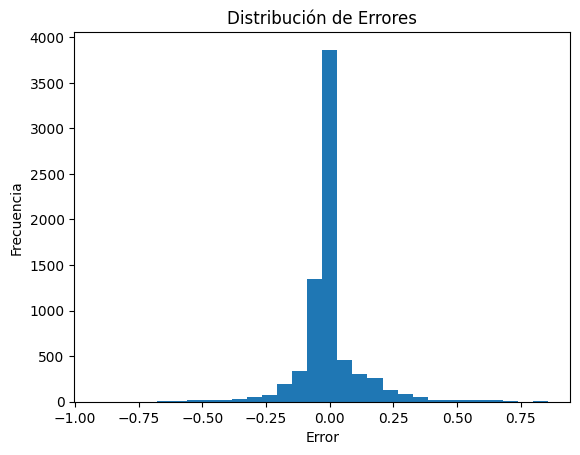

In [ ]:
# Calcular el error cuadrático medio
rmse = np.sqrt(mean_squared_error(y_test_continuous, y_pred))
print(f"Error cuadrático medio (RMSE): {rmse:.4f}")

# Calcular R² Score
r2 = r2_score(y_test_continuous, y_pred)
print(f"Coeficiente de determinación (R²): {r2:.4f}")

errors = y_test_continuous - y_pred
plt.hist(errors, bins=30)
plt.xlabel("Error")
plt.ylabel("Frecuencia")
plt.title("Distribución de Errores")
plt.show()


Prueba con n=200

In [ ]:

label_mapping = {
    'benign': 0.0,
    'spam': 0.25,
    'Defacement': 0.5,
    'phishing': 0.75,
    'malware': 1.0
}

# Convertir las etiquetas a valores continuos
y_train_continuous = y_train.map(label_mapping)
y_test_continuous = y_test.map(label_mapping)

# Verificar conversión
print("Valores originales:", set(y_train))
print("Valores convertidos:", set(y_train_continuous))

# Crear y entrenar el modelo de regresión
regressor = RandomForestRegressor(
    n_estimators=200,      
    max_depth=10,        
    min_samples_leaf=4,   
    n_jobs=-1,           
    random_state=42
)

regressor.fit(X_train, y_train_continuous)

# Hacer predicciones
y_pred = regressor.predict(X_test)

# Convertir predicciones de vuelta a etiquetas
inverse_label_mapping = {v: k for k, v in label_mapping.items()}
y_pred_labels = [inverse_label_mapping[round(val * 2) / 2] for val in y_pred]  # Redondeo a 0.0, 0.5, 1.0

# Ejemplo de predicciones finales
print("Ejemplo de predicciones:", y_pred_labels[:5])


Valores originales: {'malware', 'spam', 'benign', 'Defacement', 'phishing'}
Valores convertidos: {0.5, 0.0, 1.0, 0.25, 0.75}
Ejemplo de predicciones: ['benign', 'Defacement', 'malware', 'Defacement', 'malware']


Metricas

Error cuadrático medio (RMSE): 0.1238
Coeficiente de determinación (R²): 0.8749


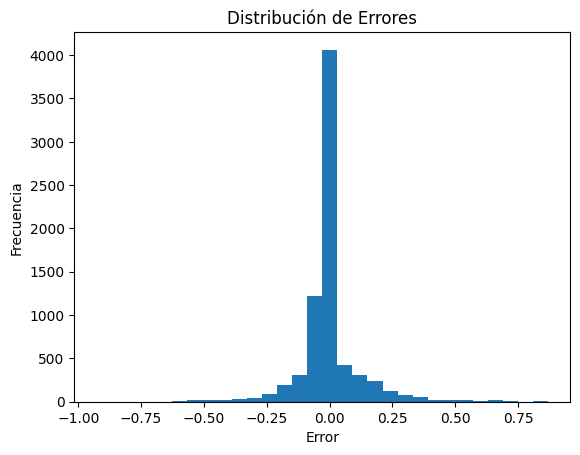

In [ ]:
# Calcular el error cuadrático medio
rmse = np.sqrt(mean_squared_error(y_test_continuous, y_pred))
print(f"Error cuadrático medio (RMSE): {rmse:.4f}")

# Calcular R² Score
r2 = r2_score(y_test_continuous, y_pred)
print(f"Coeficiente de determinación (R²): {r2:.4f}")

errors = y_test_continuous - y_pred
plt.hist(errors, bins=30)
plt.xlabel("Error")
plt.ylabel("Frecuencia")
plt.title("Distribución de Errores")
plt.show()


Prueba con n=1000

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

label_mapping = {
    'benign': 0.0,
    'spam': 0.25,
    'Defacement': 0.5,
    'phishing': 0.75,
    'malware': 1.0
}

# Convertir las etiquetas a valores continuos
y_train_continuous = y_train.map(label_mapping)
y_test_continuous = y_test.map(label_mapping)

# Verificar conversión
print("Valores originales:", set(y_train))
print("Valores convertidos:", set(y_train_continuous))

# Crear y entrenar el modelo de regresión
regressor = RandomForestRegressor(
    n_estimators=1000,      
    max_depth=10,        
    min_samples_leaf=4,   
    n_jobs=-1,           
    random_state=42
)

regressor.fit(X_train, y_train_continuous)

# Hacer predicciones
y_pred = regressor.predict(X_test)

# Convertir predicciones de vuelta a etiquetas
inverse_label_mapping = {v: k for k, v in label_mapping.items()}
y_pred_labels = [inverse_label_mapping[round(val * 2) / 2] for val in y_pred]  # Redondeo a 0.0, 0.5, 1.0

# Ejemplo de predicciones finales
print("Ejemplo de predicciones:", y_pred_labels[:5])


Valores originales: {'malware', 'spam', 'benign', 'Defacement', 'phishing'}
Valores convertidos: {0.5, 0.0, 1.0, 0.25, 0.75}
Ejemplo de predicciones: ['benign', 'Defacement', 'malware', 'Defacement', 'malware']


Metricas

In [ ]:
# Calcular el error cuadrático medio
rmse = np.sqrt(mean_squared_error(y_test_continuous, y_pred))
print(f"Error cuadrático medio (RMSE): {rmse:.4f}")

# Calcular R² Score
r2 = r2_score(y_test_continuous, y_pred)
print(f"Coeficiente de determinación (R²): {r2:.4f}")

errors = y_test_continuous - y_pred
plt.hist(errors, bins=30)
plt.xlabel("Error")
plt.ylabel("Frecuencia")
plt.title("Distribución de Errores")
plt.show()

Prueba con n=10000

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

label_mapping = {
    'benign': 0.0,
    'spam': 0.25,
    'Defacement': 0.5,
    'phishing': 0.75,
    'malware': 1.0
}

# Convertir las etiquetas a valores continuos
y_train_continuous = y_train.map(label_mapping)
y_test_continuous = y_test.map(label_mapping)

# Verificar conversión
print("Valores originales:", set(y_train))
print("Valores convertidos:", set(y_train_continuous))

# Crear y entrenar el modelo de regresión
regressor = RandomForestRegressor(
    n_estimators=10000,      
    max_depth=10,        
    min_samples_leaf=4,   
    n_jobs=-1,           
    random_state=42
)

regressor.fit(X_train, y_train_continuous)

# Hacer predicciones
y_pred = regressor.predict(X_test)

# Convertir predicciones de vuelta a etiquetas
inverse_label_mapping = {v: k for k, v in label_mapping.items()}
y_pred_labels = [inverse_label_mapping[round(val * 2) / 2] for val in y_pred]  # Redondeo a 0.0, 0.5, 1.0

# Ejemplo de predicciones finales
print("Ejemplo de predicciones:", y_pred_labels[:5])

Metricas

In [ ]:
# Calcular el error cuadrático medio
rmse = np.sqrt(mean_squared_error(y_test_continuous, y_pred))
print(f"Error cuadrático medio (RMSE): {rmse:.4f}")

# Calcular R² Score
r2 = r2_score(y_test_continuous, y_pred)
print(f"Coeficiente de determinación (R²): {r2:.4f}")

errors = y_test_continuous - y_pred
plt.hist(errors, bins=30)
plt.xlabel("Error")
plt.ylabel("Frecuencia")
plt.title("Distribución de Errores")
plt.show()

Pruebas con n=50000

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

label_mapping = {
    'benign': 0.0,
    'spam': 0.25,
    'Defacement': 0.5,
    'phishing': 0.75,
    'malware': 1.0
}

# Convertir las etiquetas a valores continuos
y_train_continuous = y_train.map(label_mapping)
y_test_continuous = y_test.map(label_mapping)

# Verificar conversión
print("Valores originales:", set(y_train))
print("Valores convertidos:", set(y_train_continuous))

# Crear y entrenar el modelo de regresión
regressor = RandomForestRegressor(
    n_estimators=50000,      
    max_depth=10,        
    min_samples_leaf=4,   
    n_jobs=-1,           
    random_state=42
)

regressor.fit(X_train, y_train_continuous)

# Hacer predicciones
y_pred = regressor.predict(X_test)

# Convertir predicciones de vuelta a etiquetas
inverse_label_mapping = {v: k for k, v in label_mapping.items()}
y_pred_labels = [inverse_label_mapping[round(val * 2) / 2] for val in y_pred]  # Redondeo a 0.0, 0.5, 1.0

# Ejemplo de predicciones finales
print("Ejemplo de predicciones:", y_pred_labels[:5])

Metricas

In [ ]:
# Calcular el error cuadrático medio
rmse = np.sqrt(mean_squared_error(y_test_continuous, y_pred))
print(f"Error cuadrático medio (RMSE): {rmse:.4f}")

# Calcular R² Score
r2 = r2_score(y_test_continuous, y_pred)
print(f"Coeficiente de determinación (R²): {r2:.4f}")

errors = y_test_continuous - y_pred
plt.hist(errors, bins=30)
plt.xlabel("Error")
plt.ylabel("Frecuencia")
plt.title("Distribución de Errores")
plt.show()